In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
from imageio import imread

import copy
import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)


In [3]:
# Create the data
nImages = 3000
imgSize = 64

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# Initialize tensors containing images and labels
images = torch.zeros(nImages, 1, imgSize, imgSize)

for i in range(nImages):
    # Create the gaussian with random centers
    ro = 2 * np.random.randn(2) # ro = random offset
    width = np.random.rand() / .6 + 1.8 # random width
    G = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * width**2))

    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)


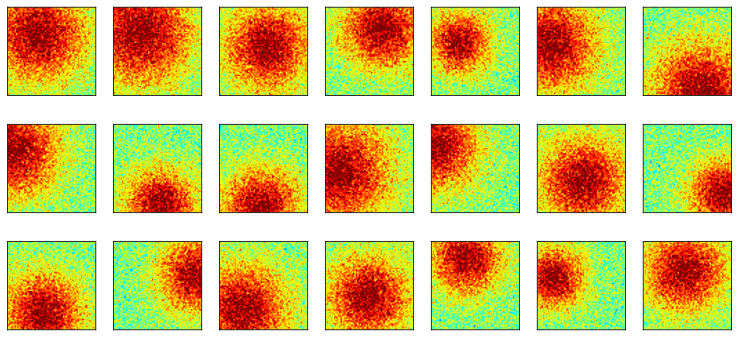

In [5]:
# visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze(images[whichpic, :, :].cpu())
    ax.imshow(G, vmin=-1, vmax=1, cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


In [ ]:
# Discriminator Model
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)


dnet = discriminatorNet()
y = dnet(torch.randn(10, 784))
y


tensor([[0.5165],
        [0.5174],
        [0.5145],
        [0.5062],
        [0.5138],
        [0.5099],
        [0.4961],
        [0.5291],
        [0.4801],
        [0.5093]], device='cuda:0', grad_fn=<SigmoidBackward0>)

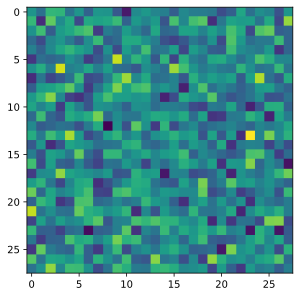

In [ ]:
# Generator Model
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)


gnet = generatorNet()
y = gnet(torch.randn(10, 64))
plt.imshow(y[0, :].cpu().detach().squeeze().view(28, 28))


In [ ]:
# Loss function
lossFun = nn.BCELoss()

# Instantiate the models and move it to the gpu
dnet = discriminatorNet().to(device=device)
gnet = generatorNet().to(device=device)

# Optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0003)


In [ ]:
# Model training
epochs = 50000
losses = np.zeros((epochs, 2))
disDecs = np.zeros((epochs, 2))

for epoch in range(epochs):

    # Create minibatchs for REAL and FAKE images
    randIdx = torch.randint(dataT.shape[0], (batchsize,))
    real_images = dataT[randIdx, :].to(device)
    fake_images = gnet(torch.randn(batchsize, 64).to(device))

    # Labels used for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    ### ---------------------Train the discriminator-------------------------###

    # Forward pass and loss for REAL picture
    pred_real = dnet(real_images)
    d_loss_real = lossFun(pred_real, real_labels)

    # Forward pass and loss for FAKE pictures
    pred_fake = dnet(fake_images)
    d_loss_fake = lossFun(pred_fake, fake_labels)

    # Collect losses using combined losses
    d_loss = d_loss_real + d_loss_fake
    losses[epoch, 0] = d_loss.cpu().item()
    disDecs[epoch, 0] = torch.mean((pred_real > 0.5).float()).cpu().detach()
    # Backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ###------------------------Train the generator-------------------------###
    # Create fake images and compute loss
    fake_images = gnet(torch.randn(batchsize, 64).to(device))
    pred_fake = dnet(fake_images)

    # Compute and collect losses
    g_loss = lossFun(pred_fake, real_labels)
    losses[epoch, 1] = g_loss.cpu().item()
    disDecs[epoch, 1] = torch.mean((pred_fake > 0.5).float()).cpu().detach()

    # Backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # Print out the status message
    if (epoch + 1) % 500 == 0:
        msg = f"Finished epoch {epoch + 1} / {epochs}"
        sys.stdout.write("\r" + msg)


Finished epoch 50000 / 50000

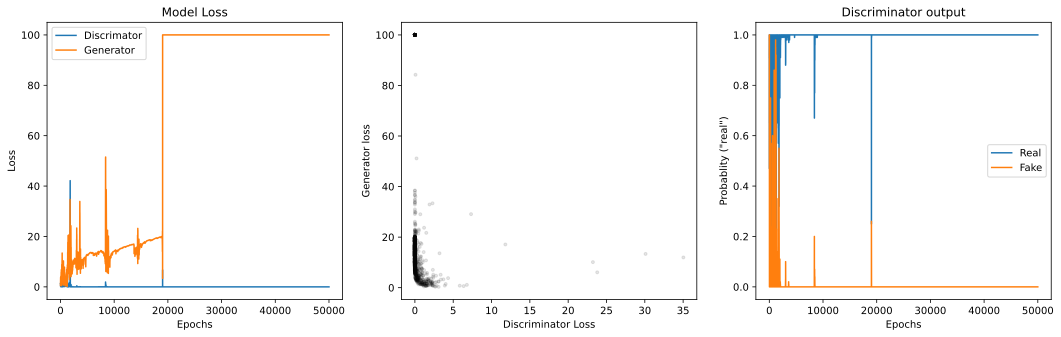

In [ ]:
# Let's draw the model loss and outputs
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Loss")
ax[0].legend(["Discrimator", "Generator"])

ax[1].plot(losses[::5, 0], losses[::5, 1], "k.", alpha=0.1)
ax[1].set_xlabel("Discriminator Loss")
ax[1].set_ylabel("Generator loss")

ax[2].plot(disDecs)
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title("Discriminator output")
ax[2].legend(["Real", "Fake"])

plt.show()


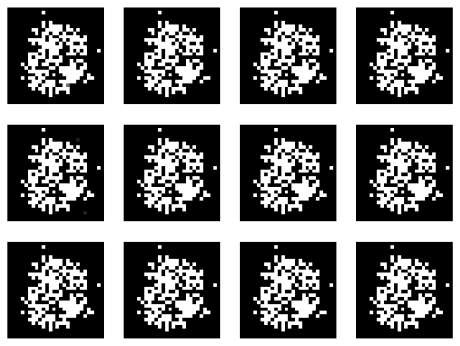

In [ ]:
# Let's see some fake digits
# Generate the images from the generator network
torch.manual_seed(1)
gnet.eval()
fake_data = gnet(torch.randn(12, 64).to(device)).cpu()

# New the visualization
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(
        fake_data[
            i,
            :,
        ]
        .detach()
        .view(28, 28),
        cmap="gray",
    )
    ax.axis("off")

plt.show()
